In [90]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ahpy

In [91]:
df = pd.read_csv("wimbledon.csv")

In [92]:
df["elapsed_time_td"] = pd.to_timedelta(df["elapsed_time"])
df["time_diff"] = df.groupby("match_id")["elapsed_time_td"].diff().dt.total_seconds().fillna(0)
df[["match_id", "elapsed_time", "time_diff"]]

,match_id,elapsed_time,time_diff
0,2023-wimbledon-1301,00:00:00,0.0
1,2023-wimbledon-1301,00:00:38,38.0
2,2023-wimbledon-1301,00:01:01,23.0
3,2023-wimbledon-1301,00:01:31,30.0
4,2023-wimbledon-1301,00:02:21,50.0
...,...,...,...
7279,2023-wimbledon-1701,04:39:58,27.0
7280,2023-wimbledon-1701,04:40:43,45.0
7281,2023-wimbledon-1701,04:41:20,37.0
7282,2023-wimbledon-1701,04:41:52,32.0


In [93]:
df_points_diff = df.groupby(["match_id", "set_no", "game_no"])[
    ["p1_points_won", "p2_points_won"]
].apply(lambda x: [entry[0] - entry[1] for entry in x.values]).reset_index(name="points_diff_list")
df_points_diff

,match_id,set_no,game_no,points_diff_list
0,2023-wimbledon-1301,1,1,"[-1, 0, -1, 0, 1, 0, 1, 0, 1, 2]"
1,2023-wimbledon-1301,1,2,"[1, 2, 3, 2, 1, 2, 1, 0]"
2,2023-wimbledon-1301,1,3,"[1, 2, 1, 2, 3]"
3,2023-wimbledon-1301,1,4,"[2, 1, 0, -1]"
4,2023-wimbledon-1301,1,5,"[0, 1, 2, 1, 0, -1, 0, 1]"
...,...,...,...,...
1183,2023-wimbledon-1701,5,6,"[-1, 0, -1, 0, 1, 2]"
1184,2023-wimbledon-1701,5,7,"[1, 2, 1, 2, 1, 0]"
1185,2023-wimbledon-1701,5,8,"[-1, 0, 1, 2, 3]"
1186,2023-wimbledon-1701,5,9,"[2, 1, 0, 1, 0]"


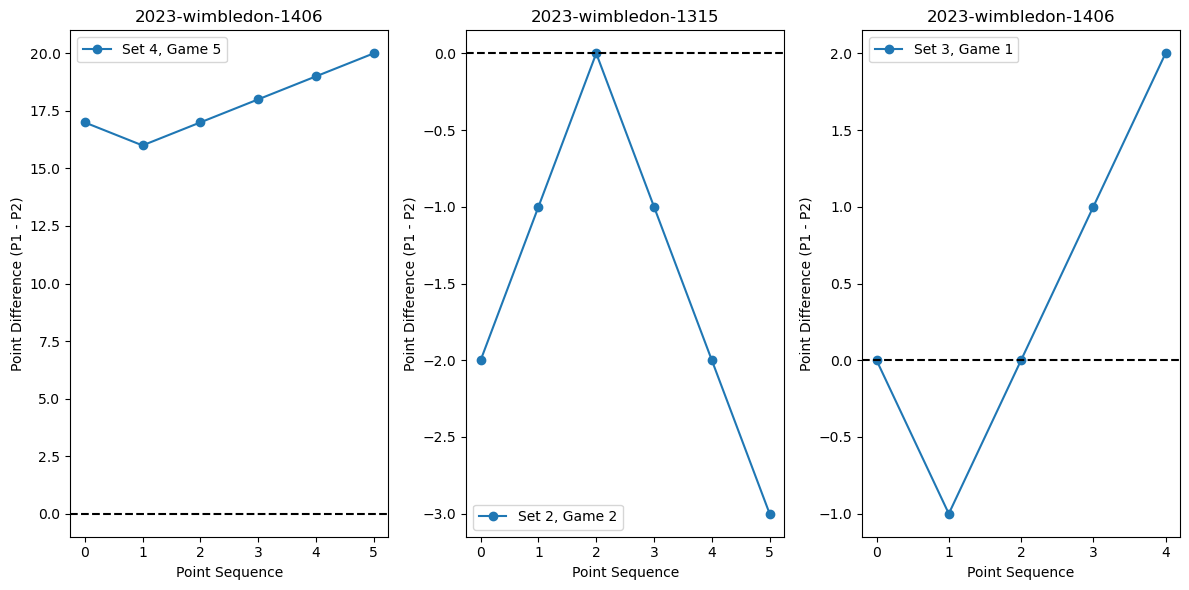

In [94]:
plt.figure(figsize=(12, 6))
for i, (match_id, set_no, game_no, points_diff_list) in df_points_diff.sample(
    3, random_state=0, ignore_index=True
).iterrows():
    plt.subplot(1, 3, i + 1)
    plt.plot(points_diff_list, marker="o", label=f"Set {set_no}, Game {game_no}")
    plt.xlabel("Point Sequence")
    plt.ylabel("Point Difference (P1 - P2)")
    plt.title(match_id)
    plt.axhline(y=0, color="black", linestyle="--")
    plt.legend()
plt.tight_layout()
plt.show()

In [95]:
df

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,elapsed_time_td,time_diff
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,6.000,7.840,2,95.0,BC,NCTL,ND,0 days 00:00:00,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,5.253,7.094,1,118.0,B,CTL,ND,0 days 00:00:38,38.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,13.800,19.808,4,120.0,B,NCTL,D,0 days 00:01:01,23.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,51.108,75.631,13,130.0,BW,CTL,D,0 days 00:01:31,30.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0.649,0.813,1,112.0,W,NCTL,NaN,0 days 00:02:21,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:39:58,5,10,330,2,2,5,...,0,38.620,50.971,11,123.0,C,NCTL,D,0 days 04:39:58,27.0
7280,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:40:43,5,10,331,2,2,5,...,0,17.533,27.766,5,114.0,W,NCTL,ND,0 days 04:40:43,45.0
7281,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:20,5,10,332,2,2,5,...,0,10.882,18.328,4,124.0,W,NCTL,D,0 days 04:41:20,37.0
7282,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,04:41:52,5,10,333,2,2,5,...,0,7.893,10.537,1,130.0,C,NCTL,D,0 days 04:41:52,32.0


In [96]:
def get_performance(*, time_diff, sets, games, ace, winner, unf_err):
    return time_diff / 100 + sets * 0.5 + games * 0.1 + ace + winner * 0.5 - unf_err * 0.5

In [97]:
df["p1_performance"] = get_performance(
    time_diff=df["time_diff"],
    sets=df["p1_sets"],
    games=df["p1_games"],
    ace=df["p1_ace"],
    winner=df["p1_winner"],
    unf_err=df["p1_unf_err"],
)
df["p2_performance"] = get_performance(
    time_diff=df["time_diff"],
    sets=df["p2_sets"],
    games=df["p2_games"],
    ace=df["p2_ace"],
    winner=df["p2_winner"],
    unf_err=df["p2_unf_err"],
)

for i, row in df.iterrows():
    if i == 0:
        if row["point_victor"] == 1:  # P1 won the point
            df.at[i, "p1_performance"] += 0.5
        else:  # P2 won the point
            df.at[i, "p2_performance"] += 0.5
    else:
        if row["point_victor"] == 1:
            if df.at[i - 1, "point_victor"] == 1:  # P1 won two consecutive points
                df.at[i, "p1_performance"] += 0.5 * 1.2
            else:  # P1 lost last point but won this point
                df.at[i, "p1_performance"] += 0.5
        else:
            if df.at[i - 1, "point_victor"] == 1:  # P1 lost last point but won this point
                df.at[i, "p2_performance"] += 0.5
            else:  # P1 lost two consecutive points
                df.at[i, "p2_performance"] += 0.5 * 1.2

df[["match_id", "p1_performance", "p2_performance"]]

,match_id,p1_performance,p2_performance
0,2023-wimbledon-1301,-0.50,0.50
1,2023-wimbledon-1301,0.88,0.38
2,2023-wimbledon-1301,-0.27,0.73
3,2023-wimbledon-1301,1.30,0.30
4,2023-wimbledon-1301,2.60,0.50
...,...,...,...
7279,2023-wimbledon-1701,2.77,1.67
7280,2023-wimbledon-1701,3.05,1.85
7281,2023-wimbledon-1701,1.87,2.77
7282,2023-wimbledon-1701,2.32,1.72


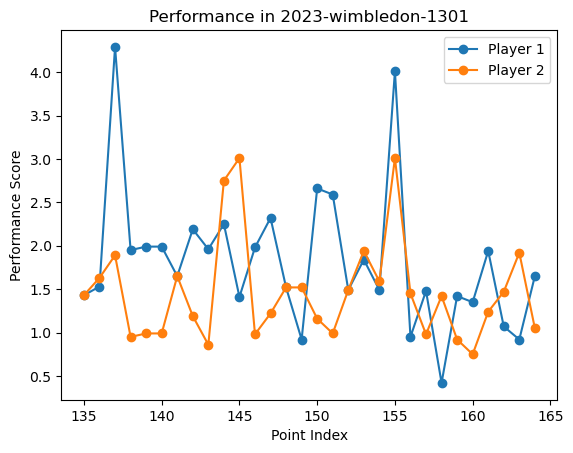

In [98]:
match_id = "2023-wimbledon-1301"
match_df = df[df["match_id"] == match_id].iloc[135:165, :]
plt.plot(match_df.index, match_df["p1_performance"], label="Player 1", marker="o")
plt.plot(match_df.index, match_df["p2_performance"], label="Player 2", marker="o")
plt.xlabel("Point Index")
plt.ylabel("Performance Score")
plt.title(f"Performance in {match_id}")
plt.legend()
plt.show()

In [107]:
performance_comparisons = {('sets', 'games'): 3/2, ('sets', 'ace'): 1/5, ('sets', 'winner'): 1/3, ('sets', 'break_pt_won'): 1/6,
			 ('sets', 'double_fault'): 1/10, ('sets', 'unf_error'): 1 / 8,
                         ('games', 'ace'): 1 / 5, ('games', 'winner'): 1 / 3, ('games', 'break_pt_won'): 1 / 6,
                         ('games', 'double_fault'): 1 / 10, ('games', 'unf_error'): 1 / 8,
                         ('ace', 'winner'): 4, ('ace', 'break_pt_won'): 1 / 2, ('ace', 'double_fault'): 1 / 4,
                         ('ace', 'unf_error'): 1 / 3,
                         ('winner', 'break_pt_won'): 1 / 4, ('winner','double_fault'): 1/4, ('winner', 'unf_error'): 1 / 3,
                         ('break_pt_won', 'double_fault'): 1/4, ('break_pt_won', 'unf_error'): 1 / 3,
                         ('double_fault', 'unf_error'): 3}
performance = ahpy.Compare(name='Performance', comparisons=performance_comparisons, precision=4, random_index='saaty')

print(performance.target_weights)
weight_dict = performance.target_weights

weight_list = []
weight_list.append(weight_dict['sets'] * 10)
weight_list.append(weight_dict['games'] * 10)
weight_list.append(weight_dict['ace'] * 10)
weight_list.append(weight_dict['winner'] * 10)
weight_list.append(weight_dict['break_pt_won'] * 10)
weight_list.append(weight_dict['double_fault'] * 10)
weight_list.append(weight_dict['unf_error'] * 10)
weight_list

{'double_fault': 0.38958, 'unf_error': 0.23444, 'break_pt_won': 0.14828, 'ace': 0.11594, 'winner': 0.06107, 'sets': 0.02675, 'games': 0.02394}


[0.2675, 0.2394, 1.1594, 0.6107, 1.4828, 3.8958, 2.3444000000000003]

In [100]:
match_id = "2023-wimbledon-1301"
match_df = df[df["match_id"] == match_id]

In [101]:
eval_df = match_df.copy()

# Explode the columns to duplicate columns for each player
eval_df["player_id"] = None
for i in eval_df.index:
    eval_df.at[i, "player_id"] = (1, 2)
eval_df = eval_df.explode("player_id").reset_index(names="point_id").set_index(["point_id", "player_id"])

# Assign info to the corresponding player
sep_cols = ["sets", "games", "ace", "winner", "break_pt_won", "double_fault", "unf_err"]
eval_df_spec_criteria = [True, True, True, True, True, False, False]
#eval_df_spec_weights = [1, 1, 1, 1, 1, 1, 1]
eval_df_spec_weights = weight_list
for col in sep_cols:
    eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

# Victor by server or receiver
eval_df["victor_by_server"] = eval_df.apply(lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]), axis=1)
eval_df["victor_by_receiver"] = eval_df.apply(lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]), axis=1)
sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
eval_df_spec_criteria = [True, True] + eval_df_spec_criteria
eval_df_spec_weights = [1, 1] + eval_df_spec_weights

eval_df_spec = eval_df[sep_cols]
eval_df_spec

victor_by_server  victor_by_receiver  sets  games  ace  \
point_id player_id                                                           
0        1                         0                   0     0      0    0   
         2                         0                   1     0      0    0   
1        1                         1                   0     0      0    0   
         2                         0                   0     0      0    0   
2        1                         0                   0     0      0    0   
...                              ...                 ...   ...    ...  ...   
297      2                         0                   0     1      5    0   
298      1                         1                   0     2      6    0   
         2                         0                   0     1      5    0   
299      1                         1                   0     2      6    0   
         2                         0                   0     1      5    0   

                    winner  break_pt_won  double_fault  unf_err  
point_id player_id                                               
0        1               0             0             0        1  
         2               0             0             0        0  
1        1               0             0             0        0  
         2               0             0             0        0  
2        1               0             0             0        1  
...                    ...           ...           ...      ...  
297      2               0             0             0        0  
298      1               0             0             0        0  
         2               0             0             0        0  
299      1               0             0             0        0  
         2               0             0             0        0  

[600 rows x 9 columns]

In [102]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm ** 2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [103]:
topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_df_spec["performance"] = topsis.fit_predict()[1]
eval_df_spec

victor_by_server  victor_by_receiver  sets  games  ace  \
point_id player_id                                                           
0        1                         0                   0     0      0    0   
         2                         0                   1     0      0    0   
1        1                         1                   0     0      0    0   
         2                         0                   0     0      0    0   
2        1                         0                   0     0      0    0   
...                              ...                 ...   ...    ...  ...   
297      2                         0                   0     1      5    0   
298      1                         1                   0     2      6    0   
         2                         0                   0     1      5    0   
299      1                         1                   0     2      6    0   
         2                         0                   0     1      5    0   

                    winner  break_pt_won  double_fault  unf_err  performance  
point_id player_id                                                            
0        1               0             0             0        1     0.644229  
         2               0             0             0        0     0.670985  
1        1               0             0             0        0     0.669425  
         2               0             0             0        0     0.667618  
2        1               0             0             0        1     0.644229  
...                    ...           ...           ...      ...          ...  
297      2               0             0             0        0     0.667824  
298      1               0             0             0        0     0.669708  
         2               0             0             0        0     0.667824  
299      1               0             0             0        0     0.669708  
         2               0             0             0        0     0.667824  

[600 rows x 10 columns]

In [104]:
p1_performance = eval_df_spec.loc[eval_df_spec.index.get_level_values("player_id") == 1, "performance"]
p2_performance = eval_df_spec.loc[eval_df_spec.index.get_level_values("player_id") == 2, "performance"]
p1_performance.index = p1_performance.index.droplevel("player_id")
p2_performance.index = p2_performance.index.droplevel("player_id")
df_performance = pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])
df_performance

,p1,p2
point_id,,
0,0.644229,0.670985
1,0.669425,0.667618
2,0.644229,0.670985
3,0.670860,0.667618
4,0.690618,0.667618
...,...,...
295,0.667899,0.671194
296,0.667899,0.672639
297,0.669708,0.667824


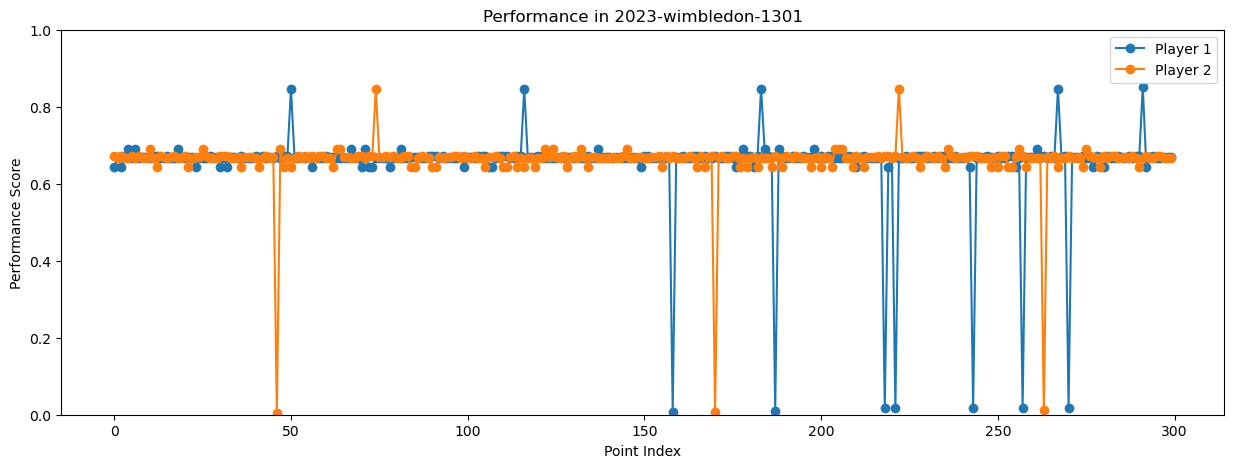

In [105]:
plt.figure(figsize=(15, 5))
plt.plot(df_performance.index, df_performance["p1"], label="Player 1", marker="o")
plt.plot(df_performance.index, df_performance["p2"], label="Player 2", marker="o")
plt.xlabel("Point Index")
plt.ylabel("Performance Score")
plt.ylim(0, 1)
plt.title(f"Performance in {match_id}")
plt.legend()
plt.show()

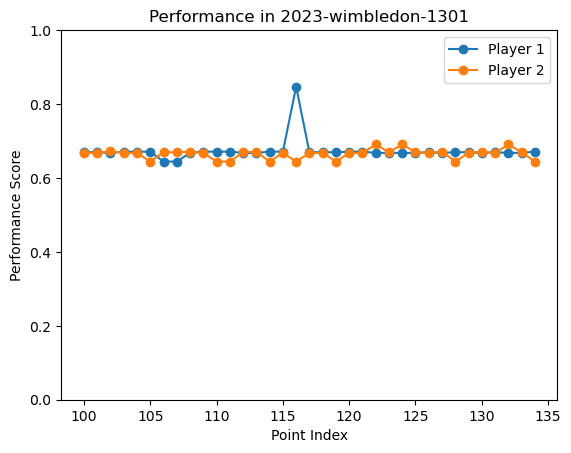

In [106]:
selected_range = list(range(100, 135))
plt.plot(selected_range, df_performance.loc[selected_range, "p1"], label="Player 1", marker="o")
plt.plot(selected_range, df_performance.loc[selected_range, "p2"], label="Player 2", marker="o")
plt.xlabel("Point Index")
plt.ylabel("Performance Score")
plt.ylim(0, 1)
plt.title(f"Performance in {match_id}")
plt.legend()
plt.show()